# Sensitivity analysis

## What is sensitivity analysis?

Sensitivity analysis is an approach to model analysis which seeks to explore how the model behaviour varies with respect to changes in model parameters.
It can be undertaken with a view to different ideas:
* We may wish to confirm that the parameter values arrived at through calibration are "optimal". Model calibration undertaken via an optimisation seeks to minimise some cost function/error, and in this situation, the introduction of perturbations to these parameter values should result in an increase in this cost function/error - in this situation, sensitivity analysis would consist of instroducing perturbations to the parameter values and exploring how the cost function varies.
* We may wish to explore variable importance. We can compare the extent to which model behaviour changes in response to changes in different parameters values, ranking variables based on which induce the greatest changes in model behaviour. In order to explore this, a cost function/error metric would again be required to quantify the behaviour of the model.
* We may simply wish to explore the model behaviour. We can explore how the model behaviour changes in response to changes in different parameter values; this could be something more visual.

We may wish to divide approaches to sensitivity analysis into two categories: local approaches and global approaches.

Local approaches seek to quantify the impact of small perturbations in model parameters.
A common approach to this is to use a one-factor-at-a-time method (OAT) whereby small perturbations are introduced to one of the model parameters in question whilst keeping all other model parameters the same, allowing us to understand the impact of changes to a model parameter in isolation.
This may, however, overlook interactions between model parameters that may lead to non-linear responses in model behaviour.

Global approaches focus on much larger ranges of parameter values, seeking to explore how the model behaviour varies in response to changes in the model parameters over all parameter space.
Furthermore, this may also explore the response of the system to simultaneous changes in multiple parameter values.

In this specific case, we wish to explore the sensitivity of the model with respect to the following parameters:
* Mean agent speed
* Standard deviation of agent speed
* Agent activation rate

In order to explore the impact of these parameters, we use the following methods:
* Visual methods: Plotting heatmap of agent positions aggregated over all frames to show parts of the model environment that are heavily frequented by agents.
* Numerical methods:
    * Error with respect to maximum number of pedestrians in environment in environment at any given time
    * Error with respect to time taken for all pedestrians to complete their journey
    * Error with respect to the time at which the maximum number of pedestrians in the system at a given time occurs

The visual approach provides us with a qualitative idea of how the model responds to changes in the inputs parameters, whereas the numerical approaches provide us with a quantitative picture.

## Setup

This section seeks to provide the groundwork for the various approaches to sensitivity analysis that will be carried out below.
In short, this means:
* Importing the required packages/modules,
* Defining paths and directories to inputs and outputs,
* Defining any constants that may be used over the course of the analysis,
* Defining any classes that we may require that aren't defined elsewhere, and
* Defining functions that we wish to use.

### Imports

Standard imports:

In [26]:
# System and files
import json
import os
import pickle
import sys
import time
from tqdm import tqdm

# Data handling
import pandas as pd
import numpy as np

# Vis
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Add `stationsim` module to path:

In [27]:
sys.path.append('../../../stationsim/')

Import `stationsim_gcs`:

In [28]:
from stationsim_gcs_model import Model

### Paths and directories

In [29]:
output_data_dir = '../outputs/data/'

In [30]:
fig_dir = '../outputs/figures/sensitivity_analysis/'

In [31]:
model_dir = '../outputs/models/'

### Constants

Observed in the previous notebooks

In [32]:
# Maximum number of pedestrians in the system at any one time
max_n_peds = 85

# Time at which the maximum number of pedestrians in the sytem occurs
t_max_n_peds = 1454

# Time at which all pedestrians have completed their trajectories
end_frame = 5687

Observed in the previous notebook

In [33]:
scaling_factor = 25/14

DEFAULT_SPEED_MEAN = 1.6026400144010877 / scaling_factor
DEFAULT_SPEED_STD = 0.6642343305178546 / scaling_factor
DEFAULT_ACTIVATION_RATE = 1.6

Required for running models and testing the outputs

In [34]:
base_model_params = {'station': 'Grand_Central',
                     'speed_min': 0.31125359137714953 / scaling_factor,
                     'step_limit': 20000,
                     'do_print': False,
                     'pop_total': 274}

In [35]:
data_results = {'n_max_active_pop': max_n_peds,
                't_max_active_pop': t_max_n_peds,
                't_max': end_frame}

### Classes

### Functions

In [36]:
def __get_error(observed, model, variable):
    return observed[variable] - model[variable]

In [37]:
def get_error(observed_results, model_results):
    """
    Calculate errors given model results and results from data.
    """
    n_max_peds = __get_error(observed_results, model_results, 'n_max_active_pop')
    t_max_peds = __get_error(observed_results, model_results, 't_max_active_pop')
    t_max = __get_error(observed_results, model_results, 't_max')
    
    results = {'n_max_active_pop': n_max_peds,
               't_max_active_pop': t_max_peds,
               't_max': t_max}
    return results

In [38]:
def run_model_local(model_params, data_results, var):
    """
    Run model, and collect error outputs.
    """
    
    model = Model(**model_params)

    n_max_active_pop = 0
    t_max_active_pop = 0
    t_max = False

    for _ in range(model.step_limit):
        model.step()

        # Update max_active_pop
        if model.pop_active > n_max_active_pop:
            n_max_active_pop = model.pop_active
            t_max_active_pop = model.step_id

        # get t_max
        if not t_max and model.step_id > 1000 and model.pop_active == 1:
            t_max = model.step_id

    model_results = {'n_max_active_pop': n_max_active_pop,
                     't_max_active_pop': t_max_active_pop,
                     't_max': t_max}

    model_errors = get_error(data_results, model_results)
    model_errors[var] = model_params[var]
    return model_errors

In [39]:
def run_model_global(model_params, data_results):
    model = Model(**model_params)

    n_max_active_pop = 0
    t_max_active_pop = 0
    t_max = False

    for _ in range(model.step_limit):
        model.step()

        # Update max_active_pop
        if model.pop_active > n_max_active_pop:
            n_max_active_pop = model.pop_active
            t_max_active_pop = model.step_id

        # get t_max
        if not t_max and model.step_id > 1000 and model.pop_active == 1:
            t_max = model.step_id

    model_results = {'n_max_active_pop': n_max_active_pop,
                     't_max_active_pop': t_max_active_pop,
                     't_max': t_max}

    model_errors = get_error(data_results, model_results)
    
    parameters = ['birth_rate', 'speed_mean', 'speed_std']
    for param in parameters:
        model_errors[param] = model_params[param]

    return model, model_errors

In [40]:
def output_model(model, model_number, model_dir, batch):
    filepath = f'{model_dir}model_{batch}_{model_number}.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

## Global analysis

In this section, we undertake a global sensitivity analysis via two approaches: a regression-based approach and a visualisation-based approach.

In the regression-based approach, we seek to fit a regression model for which we consider the following input variables:
* Mean agent speed,
* Standard deviation of agent speed,
* Agent activation rate,

and the following output variables:
* Error with respect to maximum number of pedestrians in environment in environment at any given time,
* Error with respect to time taken for all pedestrians to complete their journey,
* Error with respect to the time at which the maximum number of pedestrians in the system at a given time occurs.

This will give us a quanititative picture of how each of these response variables varies with respect to each of the model parameters outlined above, as well as how interactions between these variables may impact the response variables.

In the visualisation approach, we seek to visualise how the behaviour of the model varies with respect to changes in each of the model parameters.
These visualisations will take the form of heatmaps which detail the frequency with which different sections of the model environment are visited by pedestrians.

In order to apply each of these approaches, the model is run 5 times with the following ranges of paramter values:

| Variable        |  Calibrated value  | Minimum value | Maximum value |
|-----------------|:------------------:|:-------------:|:-------------:|
| Activation rate |       1.6          |      1.0      |     2.0       |
| Mean speed      | 0.8974784080646091 |      0.5      |     1.5       |
| Std of speed    | 0.3719712250899986 |      0.2      |     1.0       |

### Set up parameter sets

In [41]:
activation_rate_max = 2
activation_rate_min = 1

In [42]:
mean_speed_max = 1.5
mean_speed_min = 0.5

In [43]:
std_speed_max = 1
std_speed_min = 0.2

In [44]:
parameter_sets = list()
np.random.seed(666)
n_runs = 200

for _ in range(n_runs):
    mean_speed = np.random.uniform(mean_speed_min, mean_speed_max)
    std_speed = np.random.uniform(std_speed_min, std_speed_max)
    activation_rate = np.random.uniform(activation_rate_min, activation_rate_max)
    d = base_model_params.copy()
    d['speed_mean'] = mean_speed
    d['speed_std'] = std_speed
    d['birth_rate'] = activation_rate        
    parameter_sets.append(d)

In [45]:
df = pd.DataFrame(parameter_sets)
df.head()

,station,speed_min,step_limit,do_print,pop_total,speed_mean,speed_std,birth_rate
0,Grand_Central,0.174302,20000,False,274,1.200437,0.875349,1.676514
1,Grand_Central,0.174302,20000,False,274,1.227858,0.961166,1.012703
2,Grand_Central,0.174302,20000,False,274,0.913588,0.239050,1.099929
3,Grand_Central,0.174302,20000,False,274,1.008066,0.360198,1.744154
4,Grand_Central,0.174302,20000,False,274,0.692892,0.760676,1.293228


Plot the distriubtion of each of the parameters of interest:

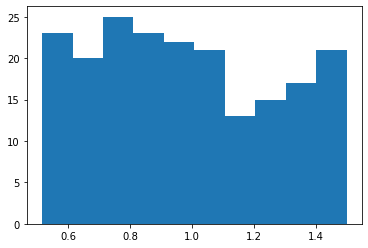

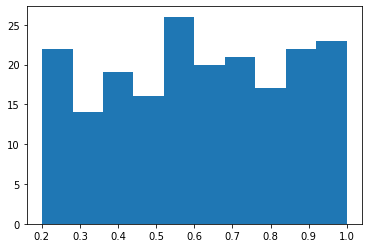

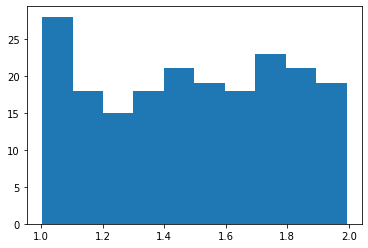

In [46]:
parameters = ['speed_mean', 'speed_std', 'birth_rate']

for param in parameters:
    plt.figure()
    plt.hist(df[param])
    plt.show()

Check for any correlation between the parameters of interest:

In [47]:
tdf = df.loc[:, parameters]
tdf.corr()

,speed_mean,speed_std,birth_rate
speed_mean,1.000000,0.008274,0.010753
speed_std,0.008274,1.000000,0.007947
birth_rate,0.010753,0.007947,1.000000


Split the runs into two batches:

In [48]:
midpoint = n_runs // 2
parameter_sets_1 = parameter_sets[: midpoint]
parameter_sets_2 = parameter_sets[midpoint :]
print(len(parameter_sets_1), len(parameter_sets_2))

100 100


### Runs

Set up containers:

In [49]:
global_results_1 = list()
global_results_2 = list()

Run first batch:

In [50]:
i = 0
for parameter_set in tqdm(parameter_sets_1):
    if i % 20 == 11:
        time.sleep(30)
    model, results = run_model_global(parameter_set, data_results)
    global_results_1.append(results)
    
    output_model(model, i, model_dir, 1)
    i += 1

100%|██████████| 100/100 [6:31:10<00:00, 234.71s/it]  


Convert the results to a dataframe and write to csv:

In [51]:
global_results_1 = pd.DataFrame(global_results_1)
global_results_1.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,11,-2618,-1268,1.676514,1.200437,0.875349
1,35,-4324,-3579,1.012703,1.227858,0.961166
2,18,-4116,-4237,1.099929,0.913588,0.239050
3,3,-2274,-1120,1.744154,1.008066,0.360198
4,11,-1679,-2814,1.293228,0.692892,0.760676


In [52]:
global_results_1.to_csv(output_data_dir + 'global_errors_1.csv', index=False)

Run second batch:

In [53]:
i = 0
for parameter_set in tqdm(parameter_sets_2):
    if i % 20 == 11:
        time.sleep(60)
    model, results = run_model_global(parameter_set, data_results)
    global_results_2.append(results)
    
    output_model(model, i, model_dir, 2)
    i += 1

100%|██████████| 100/100 [5:41:52<00:00, 205.12s/it]  


Convert the results to a dataframe and write to csv:

In [54]:
global_results_2 = pd.DataFrame(global_results_2)
global_results_2.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-9,-1382,-2491,1.649283,0.708949,0.206626
1,24,-3114,-1627,1.439688,1.282874,0.284804
2,-29,-2445,-1882,1.648376,0.591670,0.369886
3,30,-2598,-3078,1.129597,1.101797,0.574736
4,-21,-2039,-816,1.947473,0.746014,0.821157


In [55]:
global_results_2.to_csv(output_data_dir + 'global_errors_2.csv', index=False)

#### Read data back in

Read in csv:

In [56]:
global_results_1 = pd.read_csv(output_data_dir + 'global_errors_1.csv')
global_results_1.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,11,-2618,-1268,1.676514,1.200437,0.875349
1,35,-4324,-3579,1.012703,1.227858,0.961166
2,18,-4116,-4237,1.099929,0.913588,0.239050
3,3,-2274,-1120,1.744154,1.008066,0.360198
4,11,-1679,-2814,1.293228,0.692892,0.760676


In [57]:
global_results_2 = pd.read_csv(output_data_dir + 'global_errors_2.csv')
global_results_2.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-9,-1382,-2491,1.649283,0.708949,0.206626
1,24,-3114,-1627,1.439688,1.282874,0.284804
2,-29,-2445,-1882,1.648376,0.591670,0.369886
3,30,-2598,-3078,1.129597,1.101797,0.574736
4,-21,-2039,-816,1.947473,0.746014,0.821157


In [58]:
global_results = pd.concat([global_results_1, global_results_2])
global_results.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,11,-2618,-1268,1.676514,1.200437,0.875349
1,35,-4324,-3579,1.012703,1.227858,0.961166
2,18,-4116,-4237,1.099929,0.913588,0.239050
3,3,-2274,-1120,1.744154,1.008066,0.360198
4,11,-1679,-2814,1.293228,0.692892,0.760676


In [59]:
print(global_results_1.shape, global_results_2.shape, global_results.shape)

(100, 6) (100, 6) (200, 6)


### Regression setup

In [60]:
import statsmodels.api as sm

### Regression: Maximum number of pedestrians in environment

In [61]:
predictor_vars = ['birth_rate', 'speed_mean', 'speed_std']
response_var = ['n_max_active_pop']

In [62]:
Y = global_results.loc[:, response_var]
X = global_results.loc[:, predictor_vars]
X = sm.add_constant(X)

In [63]:
print(X.shape)

(200, 4)


In [64]:
print(Y.shape)

(200, 1)


In [65]:
ols = sm.OLS(Y, X).fit()

In [66]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       n_max_active_pop   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     622.8
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          6.60e-100
Time:                        09:34:37   Log-Likelihood:                -631.59
No. Observations:                 200   AIC:                             1271.
Df Residuals:                     196   BIC:                             1284.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0510      2.715      9.964      0.000      21.697      32.405
birth_rate   -44.0543      1.380    -31.920      0.000     -46.776     -41.332
speed_mean    40.8044      1.413     28.883      0.000      38.018      43.591
speed_std     10.4067      1.761      5.909      0.000       6.934      13.880
==============================================================================
Omnibus:                       36.271   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.917
Skew:                          -0.864   Prob(JB):                     8.89e-17
Kurtosis:                       5.425   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

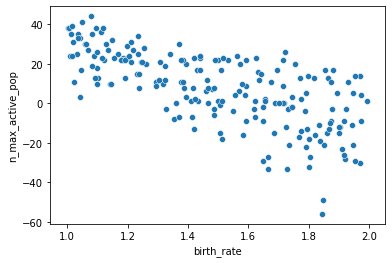

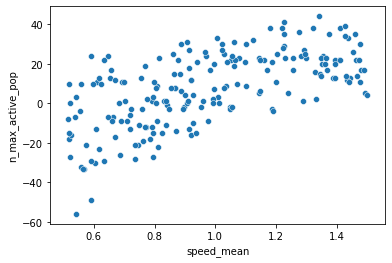

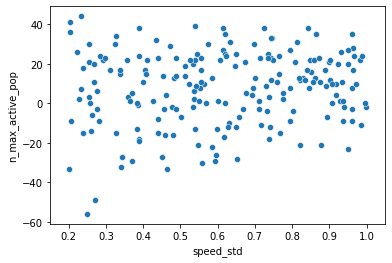

In [67]:
for predictor_var in predictor_vars:
    plt.figure()
    sns.scatterplot(x=predictor_var, y=response_var[0], data=global_results)
    plt.savefig(fig_dir + f'global/{predictor_var}_n_max_pop.pdf')
    plt.show()

### Regression: Time of maximum number of pedestrians

In [68]:
response_var = ['t_max_active_pop']

In [69]:
Y = global_results.loc[:, response_var]

In [70]:
ols = sm.OLS(Y, X).fit()

In [71]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       t_max_active_pop   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     29.23
Date:                Tue, 23 Feb 2021   Prob (F-statistic):           1.15e-15
Time:                        09:34:37   Log-Likelihood:                -1609.4
No. Observations:                 200   AIC:                             3227.
Df Residuals:                     196   BIC:                             3240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5083.6180    360.539    -14.100      0.000   -5794.651   -4372.585
birth_rate  1700.8171    183.277      9.280      0.000    1339.369    2062.265
speed_mean   217.2833    187.609      1.158      0.248    -152.709     587.275
speed_std    -30.6293    233.874     -0.131      0.896    -491.861     430.602
==============================================================================
Omnibus:                        9.727   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.176
Skew:                           0.449   Prob(JB):                      0.00617
Kurtosis:                       3.643   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

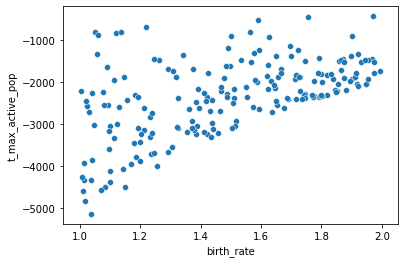

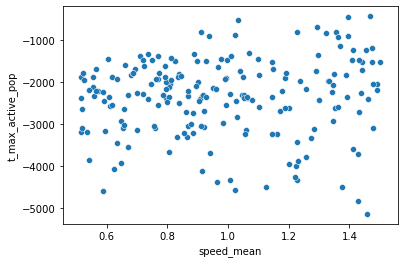

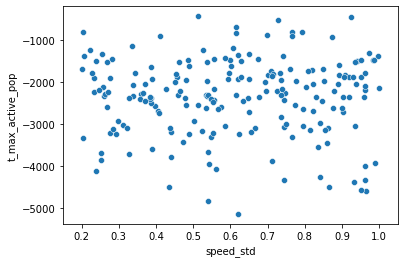

In [72]:
for predictor_var in predictor_vars:
    plt.figure()
    sns.scatterplot(x=predictor_var, y=response_var[0], data=global_results)
    plt.savefig(fig_dir + f'global/{predictor_var}_t_max_pop.pdf')
    plt.show()

### Regression: Time of completion

In [73]:
response_var = ['t_max']

In [74]:
Y = global_results.loc[:, response_var]

In [75]:
ols = sm.OLS(Y, X).fit()

In [76]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  t_max   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     148.7
Date:                Tue, 23 Feb 2021   Prob (F-statistic):           2.97e-50
Time:                        09:34:38   Log-Likelihood:                -1565.2
No. Observations:                 200   AIC:                             3138.
Df Residuals:                     196   BIC:                             3152.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7436.4232    289.133    -25.720      0.000   -8006.634   -6866.212
birth_rate  3008.5019    146.979     20.469      0.000    2718.640    3298.364
speed_mean   746.4844    150.453      4.962      0.000     449.770    1043.198
speed_std   -124.9120    187.554     -0.666      0.506    -494.795     244.971
==============================================================================
Omnibus:                      105.830   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              961.771
Skew:                          -1.796   Prob(JB):                    1.43e-209
Kurtosis:                      13.125   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

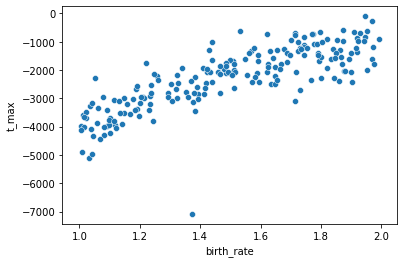

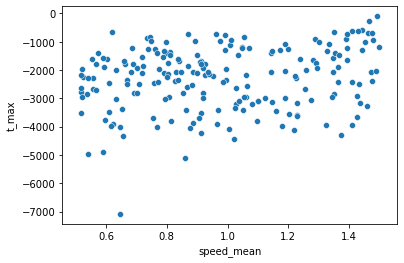

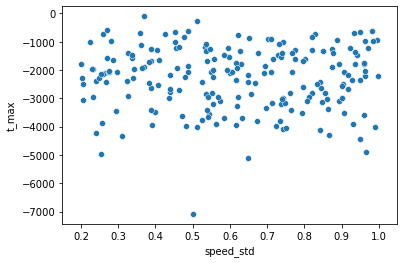

In [77]:
for predictor_var in predictor_vars:
    plt.figure()
    sns.scatterplot(x=predictor_var, y=response_var[0], data=global_results)
    plt.savefig(fig_dir + f'global/{predictor_var}_t_max.pdf')
    plt.show()

### Visualisations

Read in each of the model pickles, cataloguing them:

In [80]:
model_catalogue = list()

for filename in tqdm(os.listdir(model_dir)):
    full_filename = model_dir + filename
    if os.path.getsize(full_filename) > 0:
        with open(full_filename, 'rb') as f:
            model = pickle.load(f)

        d = {'model_path': full_filename,
             'birth_rate': model.birth_rate,
             'speed_mean': model.speed_mean,
             'speed_std': model.speed_std}
        model_catalogue.append(d)

100%|██████████| 201/201 [02:41<00:00,  1.24it/s]


In [ ]:
model_catalogue = pd.DataFrame(model_catalogue)
model_catalogue.head()

In [ ]:
model_catalogue.to_csv(output_data_dir + 'model_catalogue.csv', index=False)

In [ ]:
for variable in ['birth_rate', 'speed_mean', 'speed_std']:
    plt.figure()
    plt.hist(model_catalogue[variable])
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
slice_proportion = 5

In [ ]:
birth_rate_regimes = {'high': activation_rate_max,
                      'nominal': DEFAULT_ACTIVATION_RATE,
                      'low': activation_rate_min,
                      'step': (activation_rate_max-activation_rate_min)/slice_proportion}

speed_mean_regimes = {'high': mean_speed_max,
                      'nominal': DEFAULT_SPEED_MEAN,
                      'low': mean_speed_min,
                      'step': (mean_speed_max-mean_speed_min)/slice_proportion}

speed_std_regimes = {'high': std_speed_max,
                     'nominal': DEFAULT_SPEED_STD,
                     'low': std_speed_min,
                     'step': (std_speed_max-std_speed_min)/slice_proportion}

regimes = {'birth_rate': birth_rate_regimes,
           'speed_mean': speed_mean_regimes,
           'speed_std': speed_std_regimes}

In [ ]:
regime_names = ['high', 'nominal', 'low']

In [ ]:
def __get_set(df: pd.DataFrame, var: str, lower, upper) -> set:
    tdf = model_catalogue.loc[(model_catalogue[var] >= lower) & (model_catalogue[var] <= upper), :]
    files = set(tdf['model_path'])
    return files   

def __get_low(model_catalogue: pd.DataFrame, regimes: dict, parameter: str) -> set:
    param_regimes = regimes[parameter]
    lower = param_regimes['low']
    upper = param_regimes['low'] + param_regimes['step']
    files = __get_set(model_catalogue, parameter, lower, upper)
    return files

def __get_nominal(model_catalogue: pd.DataFrame, regimes: dict, parameter: str) -> set:
    param_regimes = regimes[parameter]
    half_step = param_regimes['step'] / 2
    lower = param_regimes['nominal'] - half_step
    upper = param_regimes['nominal'] + half_step
    files = __get_set(model_catalogue, parameter, lower, upper)
    return files

def __get_high(model_catalogue: pd.DataFrame, regimes: dict, parameter: str) -> set:
    param_regimes = regimes[parameter]
    lower = param_regimes['high'] - param_regimes['step']
    upper = param_regimes['high']
    files = __get_set(model_catalogue, parameter, lower, upper)
    return files

In [ ]:
regime_funcs = {'high': __get_high,
                'nominal': __get_nominal,
                'low': __get_low}

In [ ]:
models_by_regime = list()
for ar_regime in regime_names:
    for ms_regime in regime_names:
        for ss_regime in regime_names:
            ar_models = regime_funcs[ar_regime](model_catalogue, regimes, 'birth_rate')
            ms_models = regime_funcs[ms_regime](model_catalogue, regimes, 'speed_mean')
            ss_models = regime_funcs[ss_regime](model_catalogue, regimes, 'speed_std')
            
            model_paths = ar_models.intersection(ms_models, ss_models)
            
            d = {'birth_rate': ar_regime,
                 'speed_mean': ms_regime,
                 'speed_std': ss_regime,
                 'model_paths': list(model_paths)}
            models_by_regime.append(d)

In [ ]:
models_by_regime = pd.DataFrame(models_by_regime)
models_by_regime.head()

In [ ]:
def __is_empty_list(row):
    return row['model_paths'] == []

In [ ]:
def __get_n_paths(row):
    return len(row['model_paths'])

In [ ]:
models_by_regime['no_paths'] = models_by_regime.apply(__is_empty_list, axis=1)
models_by_regime['n_paths'] = models_by_regime.apply(__get_n_paths, axis=1)

In [ ]:
sum(models_by_regime['no_paths'])

In [ ]:
plt.figure()
plt.hist(models_by_regime['n_paths'])
plt.ylabel('Frequency')
plt.xlabel('Number of models for a given parameter regime combination')
plt.show()

In [ ]:
models_by_regime.loc[models_by_regime['birth_rate']=='nominal', :]

In [ ]:
models_by_regime.loc[models_by_regime['speed_mean']=='nominal', :]

In [ ]:
models_by_regime.loc[models_by_regime['speed_std']=='nominal', :]